In [3]:
import numpy as np
import pickle
import os
import gzip
from matplotlib import pyplot as plt
%matplotlib inline

# First exercise: Classifying MNIST with MLPs
In this exercise you will implement a Neural Network (or MLP) and classify the MNIST digits with it.
MNIST is a "well hung" dataset that has been used a lot over the years to benchmark different classification algorithms. 
To learn more about it have a look here: http://yann.lecun.com/exdb/mnist/ .

# Data Loading
We first define a function for downloading and loading MNIST.
**WARNING**: Executing it will obviously use up some space on your machine ;). 

In [4]:
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval

# Neural Network Layers
We now define bare bones neural network layers.
The parts marked with TODO are were you should finish the implementation!
Conceptually we will implement the layers as follows:

Each layer is constructed with an input layer plus some additional arguments such as layer size and activation function. The layer then uses the provided input layer to compute the layer dimensions, weight shapes, etc. and setup all auxilliary variables.

Each layer then has to provide three functions (as defined in the Layer class below): output_shape(), fprop() and brop(). The output_shape function is used to figure out the shape for the next layer and the fprop()/bprop() functions are used to compute forward and backward passes through the network.

In [5]:
# start by defining simple helpers
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def sigmoid_d(x):
    s = sigmoid(x)
    return s * (1 - s)


def tanh(x):
    return np.tanh(x)


def tanh_d(x):
    return 1 - ((tanh(x)) ** 2)


def relu(x):
    return np.maximum(0.0, x)


def relu_d(x):
    dx = np.zeros(x.shape)
    dx[x >= 0] = 1
    return dx


def linear(x):
    return x


def liear_d(x):
    return np.ones_like(x)


def softmax(x, axis=1):
    # to make the softmax a "safe" operation we will 
    # first subtract the maximum along the specified axis
    # so that np.exp(x) does not blow up!
    # Note that this does not change the output.
    x_max = np.max(x, axis=axis, keepdims=True)
    x_safe = x - x_max
    e_x = np.exp(x_safe)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)


def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels


def unhot(one_hot_labels):
    """ Invert a one hot encoding, creating a flat vector """
    return np.argmax(one_hot_labels, axis=-1)


# then define an activation function class
class Activation(object):
    def __init__(self, tname):
        if tname == 'sigmoid':
            self.act = sigmoid
            self.act_d = sigmoid_d
        elif tname == 'tanh':
            self.act = tanh
            self.act_d = tanh_d
        elif tname == 'relu':
            self.act = relu
            self.act_d = relu_d
        elif tname == 'linear':
            self.act = linear
            self.act_d = linear_d
        else:
            raise ValueError('Invalid activation function.')

    def fprop(self, input):
        # we need to remember the last input
        # so that we can calculate the derivative with respect
        # to it later on
        self.last_input = input
        return self.act(input)

    def bprop(self, output_grad):
        return output_grad * self.act_d(self.last_input)


# define a base class for layers
class Layer(object):
    def fprop(self, input):
        """ Calculate layer output for given input 
            (forward propagation). 
        """
        raise NotImplementedError()

    def bprop(self, output_grad):
        """ Calculate input gradient and gradient 
            with respect to weights and bias (backpropagation). 
        """
        raise NotImplementedError()

    def output_size(self):
        """ Calculate size of this layer's output.
        input_shape[0] is the number of samples in the input.
        input_shape[1:] is the shape of the feature.
        """
        raise NotImplementedError()


# define a base class for loss outputs
# an output layer can then simply be derived
# from both Layer and Loss 
class Loss(object):
    def loss(self, output, output_net):
        """ Calculate mean loss given real output and network output. """
        raise NotImplementedError()

    def input_grad(self, output, output_net):
        """ Calculate input gradient real output and network output. """
        raise NotImplementedError()


# define a base class for parameterized things        
class Parameterized(object):
    def params(self):
        """ Return parameters (by reference) """
        raise NotImplementedError()

    def grad_params(self):
        """ Return accumulated gradient with respect to params. """
        raise NotImplementedError()


# define a container for providing input to the network
class InputLayer(Layer):
    def __init__(self, input_shape):
        if not isinstance(input_shape, tuple):
            raise ValueError("InputLayer requires input_shape as a tuple")
        self.input_shape = input_shape
        
        print("----")
        print("Input Layer")
        print("    InputShape", self.input_shape) 

    def output_size(self):
        return self.input_shape

    def fprop(self, input):
        return input

    def bprop(self, output_grad):
        return output_grad


class FullyConnectedLayer(Layer, Parameterized):
    """ A standard fully connected hidden layer, as discussed in the lecture.
    """

    def __init__(self, input_layer, num_units,
                 init_stddev, activation_fun=Activation('relu')):
        self.num_units = num_units
        self.activation_fun = activation_fun
        # the input shape will be of size (batch_size, num_units_prev) 
        # where num_units_prev is the number of units in the input 
        # (previous) layer
        self.input_shape = input_layer.output_size()
        
        print("----")
        print("FullyConnectedLayer")
        print("    NumUnits", self.num_units)
        print("    Activation", self.num_units)
        print("    InputShape", self.input_shape)   
    
        # this is the weight matrix it should have shape: (num_units_prev, num_units)
        self.W = np.random.randn(self.input_shape[1], self.num_units) * init_stddev
        
        # and this is the bias vector of shape: (num_units)
        # Init with 0 as bias will be adjusted accordingly
        self.b = np.zeros(self.num_units)  
        
        # create dummy variables for parameter gradients
        self.dW = None
        self.db = None
        self.last_input = None

    def output_size(self):
        return (self.input_shape[0], self.num_units)

    def fprop(self, input):
        self.last_input = input
        
        activation = np.dot(input, self.W) + self.b
    
        # Handle case where activation function is None
        if self.activation_fun == None:
            return activation
        return self.activation_fun.fprop(activation)

    def bprop(self, output_grad):
        """ Calculate input gradient (backpropagation). """
        n = output_grad.shape[0]
        
        # dL/da = output_grad_act
        output_grad_act = None
        if self.activation_fun is None:
            output_grad_act = output_grad
        else:
            output_grad_act = self.activation_fun.bprop(output_grad)

        # dL/dW = dL/da * da/dW = dL/da * z
        # dL/da = activation.backprop
        # da/dW = z = last input
        self.dW = np.dot(self.last_input.T, output_grad_act) / n
        
        # dL/db = dL/da * da/db = dL/da * 1
        # bias has has to be normed for all outputs
        self.db = np.mean(output_grad_act, axis=0)
        
        # dL/dz = dL/da * da/dz = dL/da * w
        grad_input = np.dot(output_grad_act, self.W.T)
        return grad_input

    def params(self):
        return self.W, self.b

    def grad_params(self):
        return self.dW, self.db


# finally we specify the interface for output layers 
# which are layers that also have a loss function
# we will implement two output layers:
#  a Linear, and Softmax (Logistic Regression) layer
# The difference between output layers and and normal 
# layers is that they will be called to compute the gradient
# of the loss through input_grad(). bprop will never 
# be called on them!
class LinearOutput(Layer, Loss):
    """ A simple linear output layer that  
        uses a squared loss (e.g. should be used for regression)
    """
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
        print("----")
        print("Linear Output")
        print("    Input Size", self.input_size) 

    def output_size(self):
        return (1,)

    def fprop(self, input):
        return input

    def bprop(self, output_grad):
        raise NotImplementedError(
            'LinearOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )

    def input_grad(self, Y, Y_pred):
        return -(Y - Y_pred)

    def loss(self, Y, Y_pred):
        loss = 0.5 * np.square(Y - Y_pred)
        return np.mean(np.sum(loss, axis=1))


class SoftmaxOutput(Layer, Loss):
    """ A softmax output layer that calculates 
        the negative log likelihood as loss
        and should be used for classification.
    """

    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
        print("----")
        print("Softmax Output")
        print("    Input Size", self.input_size) 
        

    def output_size(self):
        return (1,)

    def fprop(self, input):
        return softmax(input)

    def bprop(self, output_grad):
        raise NotImplementedError(
            'SoftmaxOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )

    def input_grad(self, Y, Y_pred):
        return -(Y - Y_pred)

    def loss(self, Y, Y_pred):
        # Assume one-hot encoding of Y
        # and Y_pred is softmax already
        eps = 1e-10
        loss = -np.sum(Y * np.log(Y_pred + eps))
        return loss / Y.shape[0]


# Neural Network class
With all layers in place (and properly implemented by you) we can finally define a neural network.
For our purposes a neural network is simply a collection of layers which we will cycle through and on which we will call fprop and bprop to compute partial derivatives with respect to the input and the parameters.

Pay special attention to the *check_gradients* function in which you should implement automatic differentiation. This function will become your best friend when checking the correctness of your implementation.

In [7]:

class NeuralNetwork:
    """ Our Neural Network container class.
    """
    def __init__(self, layers):
        self.layers = layers
        
    def _loss(self, X, Y):
        Y_pred = self.predict(X)
        return self.layers[-1].loss(Y, Y_pred)

    def predict(self, X):
        """ Calculate an output Y for the given input X. """

        # Value which gets propagated through the network
        prop_val = X
        for layer in self.layers:
            prop_val = layer.fprop(prop_val)

        # Return propagated value = Y_pred
        return prop_val
    
    def backpropagate(self, Y, Y_pred, upto=0):
        """ Backpropagation of partial derivatives through 
            the complete network up to layer 'upto'
        """
        next_grad = self.layers[-1].input_grad(Y, Y_pred)
        
        # Iterate backwards through network up to layer from param
        for layer in reversed(self.layers[upto:-1]):
            next_grad = layer.bprop(next_grad)
        return next_grad
   
    def classification_error_with_list(self, X, Y, withList=True):
        """ Calculate error on the given data 
            assuming they are classes that should be predicted. 
            Additionally returns list of correctly / uncorrectly 
            classified elements
        """
        Y_pred = unhot(self.predict(X))
        error = Y_pred != Y
        
        if withList:
            return np.mean(error), error
        
        return np.mean(error) 
    
    def classification_error(self, X, Y):
        """ Calculate error on the given data 
            assuming they are classes that should be predicted. 
        """
        return self.classification_error_with_list(X, Y, False)
    
    
    def sgd_epoch(self, X, Y, learning_rate, batch_size):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        for b in range(n_batches):
            batch_begin = b * batch_size
            batch_end = batch_begin + batch_size
            X_batch = X[batch_begin:batch_end]
            Y_batch = Y[batch_begin:batch_end]

            # Forward
            Y_pred = self.predict(X_batch)

            # Backward
            self.backpropagate(Y_batch, Y_pred)

            for layer in self.layers:
                if isinstance(layer, Parameterized):
                    # Get params (getters are by reference for in place edit)
                    param_tuples = zip(layer.params(), layer.grad_params())
                    for param, grad in param_tuples:
                        param -= grad * learning_rate
    
    def gd_epoch(self, X, Y, learning_rate):        
        # Y_pred = self.predict(X)
        # self.backpropagate(Y, Y_pred)
        # 
        # for layer in self.layers:
        #     if isinstance(layer, Parameterized):
        #         # Get params (getters are by reference for in place edit)
        #         param_tuples = zip(layer.params(), layer.grad_params())
        #         for param, grad in param_tuples:
        #             param -= grad * learning_rate
        return self.sgd_epoch(X, Y, learning_rate, X.shape[0])
       
    
    def train(self, X, Y, X_valid=None, Y_valid=None, 
              learning_rate=0.1, max_epochs=100, 
              batch_size=64, descent_type="sgd", y_one_hot=True):
        """ Train network on the given data. """
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        if y_one_hot:
            Y_train = one_hot(Y)
        else:
            Y_train = Y
        print("... starting training")
        
        num_epochs = max_epochs + 1  # +1 from predefined range

         # Store errors of each epoch
        train_errors = np.zeros(num_epochs)
        val_errors = np.zeros(num_epochs)
        
        for e in range(num_epochs):
            if descent_type == "sgd":
                self.sgd_epoch(X, Y_train, learning_rate, batch_size)
            elif descent_type == "gd":
                self.gd_epoch(X, Y_train, learning_rate)
            else:
                raise NotImplemented("Unknown gradient descent type {}".format(descent_type))

            # Output error on the training data
            train_loss = self._loss(X, Y_train)
            train_errors[e] = self.classification_error(X, Y)
            print('epoch {:4d}, loss {:.4f}, train error {:.4f}'.format(e, train_loss, train_errors[e]))
            if X_valid is not None:
                val_errors[e] = self.classification_error(X_valid, Y_valid)
                print('                         val error   {:.4f}'.format(val_errors[e]))
        
        return train_errors, val_errors
    
    def test(self, X, Y, y_one_hot=True):
        # See train method
        if y_one_hot:
            Y_train = one_hot(Y)
        else:
            Y_train = Y
            
        test_loss = self._loss(X, Y_train)
        test_error, classifications = self.classification_error_with_list(X, Y)
        
        return test_loss, test_error, classifications
    
    def check_gradients(self, X, Y):
        """ Helper function to test the parameter gradients for
        correctness. """
        for l, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):
                print('checking gradient for layer {}'.format(l))
                for p, param in enumerate(layer.params()):
                    # we iterate through all parameters
                    param_shape = param.shape
                    # define functions for conveniently swapping
                    # out parameters of this specific layer and 
                    # computing loss and gradient with these 
                    # changed parametrs
                    def output_given_params(param_new):
                        """ A function that will compute the output 
                            of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # return computed loss
                        return self._loss(X, Y)

                    def grad_given_params(param_new):
                        """A function that will compute the gradient 
                           of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # Forward propagation through the net
                        Y_pred = self.predict(X)
                        # Backpropagation of partial derivatives
                        self.backpropagate(Y, Y_pred, upto=l)
                        # return the computed gradient 
                        return np.ravel(self.layers[l].grad_params()[p])

                    # let the initial parameters be the ones that
                    # are currently placed in the network and flatten them
                    # to a vector for convenient comparisons, printing etc.
                    param_init = np.ravel(np.copy(param))
                    
                    # making sure your gradient checking routine itself 
                    # has no errors can be a bit tricky. To debug it
                    # you can "cheat" by using scipy which implements
                    # gradient checking exactly the way you should!
                    # To do that simply run the following here:
                    import scipy.optimize
                    err = scipy.optimize.check_grad(output_given_params, grad_given_params, param_init)
                    print('Scipy Err  {:.2e}'.format(err))
                    
                    epsilon = 1e-4
                    loss_base = output_given_params(param_init)
                    gparam_bprop = grad_given_params(param_init)
                    gparam_fd = np.zeros_like(param_init)
                    
                    # Iterate over all params
                    # See https://www.youtube.com/watch?v=pHMzNW8Agq4
                    for i in range(len(param_init)):

                        # Calculate numeric gradient
                        param_init[i] += epsilon  # After tip its working...
                        gparam_fd[i] = (output_given_params(param_init) - loss_base) / (epsilon)
                        param_init[i] -= epsilon
                    
                    err = np.mean(np.abs(gparam_bprop - gparam_fd))
                    print('Calculated {:.2e}'.format(err))
                    assert(err < epsilon)
                    
                    # reset the parameters to their initial values
                    param[:] = np.reshape(param_init, param_shape)

# Gradient Checking
After implementing everything it is always a good idea to setup some layers and perform gradient
checking on random data. *Note* that this is only an example! It is not a useful networ architecture ;). We also expect you to play around with this to test all your implemented components.

In [8]:
input_shape = (5, 10)
n_labels = 6
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
    layers[-1],
    num_units=15,
    init_stddev=0.1,
    activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
    layers[-1],
    num_units=6,
    init_stddev=0.1,
    activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
    layers[-1],
    num_units=n_labels,
    init_stddev=0.1,
    activation_fun=Activation('relu')
))
layers.append(SoftmaxOutput(layers[-1]))
nn = NeuralNetwork(layers)


----
Input Layer
    InputShape (5, 10)
----
FullyConnectedLayer
    NumUnits 15
    Activation 15
    InputShape (5, 10)
----
FullyConnectedLayer
    NumUnits 6
    Activation 6
    InputShape (5, 15)
----
FullyConnectedLayer
    NumUnits 6
    Activation 6
    InputShape (5, 6)
----
Softmax Output
    Input Size (5, 6)


In [9]:
# create random data
X = np.random.normal(size=input_shape)
# and random labels
Y = np.zeros((input_shape[0], n_labels))
for i in range(Y.shape[0]):
    idx = np.random.randint(n_labels)
    Y[i, idx] = 1.


In [10]:
nn.check_gradients(X, Y)


checking gradient for layer 1


Scipy Err  1.38e-07
Calculated 8.68e-09
Scipy Err  4.57e-08
Calculated 6.93e-09
checking gradient for layer 2
Scipy Err  1.10e-07
Calculated 9.79e-09
Scipy Err  3.20e-08
Calculated 2.09e-07
checking gradient for layer 3
Scipy Err  5.46e-08
Calculated 1.10e-08
Scipy Err  2.09e-08
Calculated 2.56e-06


# Training on MNIST
Finally we can let our network run on the MNIST dataset!

First load the data and reshape it.

In [17]:
# load
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval
# Downsample training data to make it a bit faster for testing this code
n_train_samples = 10000
train_idxs = np.random.permutation(X_train.shape[0])[:n_train_samples]
X_train = X_train[train_idxs]
y_train = y_train[train_idxs]

... loading data


... done loading data


Dtrain contains 50k images Dtrain which are of size 28 x 28 pixels. Hence:

In [18]:
print("X_train shape: {}".format(np.shape(X_train)))
print("y_train shape: {}".format(np.shape(y_train)))


X_train shape: (10000, 1, 28, 28)
y_train shape: (10000,)


y_train will automatically be converted in the train() function to one_hot encoding.


But we need to reshape X_train, as our Network expects flat vectors of size 28*28 as input!

In [19]:
X_train = X_train.reshape(X_train.shape[0], -1)
print("Reshaped X_train size: {}".format(X_train.shape))
X_valid = X_valid.reshape((X_valid.shape[0], -1))
print("Reshaped X_valid size: {}".format(X_valid.shape))

Reshaped X_train size: (10000, 784)
Reshaped X_valid size: (10000, 784)


Ah, much better ;-)! 

Now we can finally really start training a Network!


I pre-defined a small Network for you below. Again This is not really a good default and will not produce state of the art results. Please play around with this a bit. See how different activation functions and training procedures (gd / sgd) affect the result.

----
Input Layer
    InputShape (None, 784)
----
FullyConnectedLayer
    NumUnits 300
    Activation 300
    InputShape (None, 784)
----
FullyConnectedLayer
    NumUnits 100
    Activation 100
    InputShape (None, 300)
----
FullyConnectedLayer
    NumUnits 10
    Activation 10
    InputShape (None, 100)
----
Softmax Output
    Input Size (None, 10)
... starting training


epoch    0, loss 2.2909, train error 0.8269
                         val error   0.8270


epoch    1, loss 0.9999, train error 0.3099
                         val error   0.2840


epoch    2, loss 0.6225, train error 0.1950
                         val error   0.1831


epoch    3, loss 0.4701, train error 0.1370
                         val error   0.1390


epoch    4, loss 0.3822, train error 0.1068
                         val error   0.1149


epoch    5, loss 0.3218, train error 0.0893
                         val error   0.0978


epoch    6, loss 0.2760, train error 0.0768
                         val error   0.0856


epoch    7, loss 0.2381, train error 0.0676
                         val error   0.0767


epoch    8, loss 0.2061, train error 0.0597
                         val error   0.0696


epoch    9, loss 0.1788, train error 0.0515
                         val error   0.0643


epoch   10, loss 0.1562, train error 0.0454
                         val error   0.0609


epoch   11, loss 0.1368, train error 0.0396
                         val error   0.0578


epoch   12, loss 0.1203, train error 0.0346
                         val error   0.0547


epoch   13, loss 0.1066, train error 0.0295
                         val error   0.0537


epoch   14, loss 0.0950, train error 0.0268
                         val error   0.0519


epoch   15, loss 0.0847, train error 0.0239
                         val error   0.0508


epoch   16, loss 0.0750, train error 0.0209
                         val error   0.0499


epoch   17, loss 0.0660, train error 0.0181
                         val error   0.0493


epoch   18, loss 0.0578, train error 0.0149
                         val error   0.0490


epoch   19, loss 0.0497, train error 0.0124
                         val error   0.0488


epoch   20, loss 0.0432, train error 0.0114
                         val error   0.0477


epoch   21, loss 0.0379, train error 0.0095
                         val error   0.0461


epoch   22, loss 0.0331, train error 0.0078
                         val error   0.0457


epoch   23, loss 0.0294, train error 0.0069
                         val error   0.0461


epoch   24, loss 0.0258, train error 0.0056
                         val error   0.0454


epoch   25, loss 0.0229, train error 0.0047
                         val error   0.0452


epoch   26, loss 0.0203, train error 0.0043
                         val error   0.0446


epoch   27, loss 0.0181, train error 0.0039
                         val error   0.0440


epoch   28, loss 0.0162, train error 0.0031
                         val error   0.0436


epoch   29, loss 0.0145, train error 0.0026
                         val error   0.0431


epoch   30, loss 0.0131, train error 0.0024
                         val error   0.0428


epoch   31, loss 0.0119, train error 0.0019
                         val error   0.0424


epoch   32, loss 0.0109, train error 0.0015
                         val error   0.0420


epoch   33, loss 0.0099, train error 0.0013
                         val error   0.0422


epoch   34, loss 0.0092, train error 0.0012
                         val error   0.0422


epoch   35, loss 0.0085, train error 0.0012
                         val error   0.0421


epoch   36, loss 0.0079, train error 0.0011
                         val error   0.0420


epoch   37, loss 0.0073, train error 0.0011
                         val error   0.0418


epoch   38, loss 0.0068, train error 0.0010
                         val error   0.0419


epoch   39, loss 0.0064, train error 0.0009
                         val error   0.0419


epoch   40, loss 0.0060, train error 0.0008
                         val error   0.0416


epoch   41, loss 0.0057, train error 0.0007
                         val error   0.0417


epoch   42, loss 0.0054, train error 0.0006
                         val error   0.0416


epoch   43, loss 0.0051, train error 0.0005
                         val error   0.0415


epoch   44, loss 0.0048, train error 0.0005
                         val error   0.0414


epoch   45, loss 0.0046, train error 0.0004
                         val error   0.0414


epoch   46, loss 0.0044, train error 0.0004
                         val error   0.0413


epoch   47, loss 0.0042, train error 0.0004
                         val error   0.0411


epoch   48, loss 0.0040, train error 0.0004
                         val error   0.0410


epoch   49, loss 0.0039, train error 0.0004
                         val error   0.0409


epoch   50, loss 0.0037, train error 0.0004
                         val error   0.0407


epoch   51, loss 0.0036, train error 0.0004
                         val error   0.0407


epoch   52, loss 0.0034, train error 0.0004
                         val error   0.0405


epoch   53, loss 0.0033, train error 0.0004
                         val error   0.0406


epoch   54, loss 0.0032, train error 0.0004
                         val error   0.0405


epoch   55, loss 0.0031, train error 0.0004
                         val error   0.0406
Duration: 69.6s


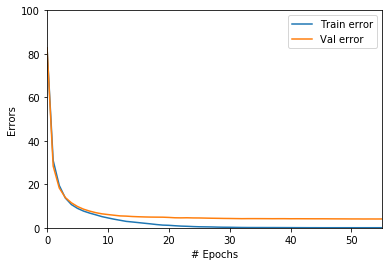

In [42]:
import time

# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
input_shape = (None, 28 * 28)
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
    layers[-1],
    num_units=300,
    init_stddev=0.01,
    activation_fun=Activation('relu')
))


layers.append(FullyConnectedLayer(
    layers[-1],
    num_units=100,
    init_stddev=0.01,
    activation_fun=Activation('relu')
))


layers.append(FullyConnectedLayer(
    layers[-1],
    num_units=10,
    init_stddev=0.01,
    # last layer has no nonlinearity 
    # (softmax will be applied in the output layer)
    activation_fun=None
))
layers.append(SoftmaxOutput(layers[-1]))

nn = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
num_epochs = 50
train_errors, val_errors = nn.train(X_train, y_train, 
                    X_valid, y_valid, learning_rate=0.1, 
         max_epochs=num_epochs, batch_size=64,
            y_one_hot=True, descent_type="sgd")
t1 = time.time()
print('Duration: {:.1f}s'.format(t1 - t0))

plt.axis([0, num_epochs, 0, 100])
plt.xlabel("# Epochs")
plt.ylabel("Errors")
plt.plot(train_errors * 100, label='Train error')
plt.plot(val_errors * 100, label='Val error')
plt.legend()
plt.savefig("Train.png")
plt.show()


# Figure out a reasonable Network that achieves good performance
As the last part of this task, setup a network that works well and gets reasonable accuracy, say ~ 1-3 percent error on the **validation set**. 
Train this network on the complete data and compute the **test error**. 

Once you have done this, visualize a few digits from the the test set that the network gets right as well as a few that the network gets wrong!


----
Input Layer
    InputShape (None, 784)
----
FullyConnectedLayer
    NumUnits 300
    Activation 300
    InputShape (None, 784)
----
FullyConnectedLayer
    NumUnits 100
    Activation 100
    InputShape (None, 300)
----
FullyConnectedLayer
    NumUnits 10
    Activation 10
    InputShape (None, 100)
----
Softmax Output
    Input Size (None, 10)
... loading data


... done loading data
Reshaped X_train size: (60000, 784)
Reshaped X_test size: (10000, 784)
... starting training


epoch    0, loss 0.3715, train error 0.1146


epoch    1, loss 0.2049, train error 0.0619


epoch    2, loss 0.1382, train error 0.0416


epoch    3, loss 0.1017, train error 0.0309


epoch    4, loss 0.0792, train error 0.0241


epoch    5, loss 0.0629, train error 0.0187


epoch    6, loss 0.0521, train error 0.0151


epoch    7, loss 0.0459, train error 0.0140


epoch    8, loss 0.0385, train error 0.0117


epoch    9, loss 0.0335, train error 0.0103


epoch   10, loss 0.0288, train error 0.0087


epoch   11, loss 0.0244, train error 0.0073


epoch   12, loss 0.0205, train error 0.0059


epoch   13, loss 0.0171, train error 0.0049


epoch   14, loss 0.0147, train error 0.0041


epoch   15, loss 0.0130, train error 0.0037


epoch   16, loss 0.0119, train error 0.0034


epoch   17, loss 0.0099, train error 0.0027


epoch   18, loss 0.0084, train error 0.0022


epoch   19, loss 0.0070, train error 0.0016


epoch   20, loss 0.0056, train error 0.0012


epoch   21, loss 0.0047, train error 0.0009


epoch   22, loss 0.0042, train error 0.0008


epoch   23, loss 0.0036, train error 0.0005


epoch   24, loss 0.0032, train error 0.0005


epoch   25, loss 0.0028, train error 0.0004


epoch   26, loss 0.0026, train error 0.0003


epoch   27, loss 0.0023, train error 0.0002


epoch   28, loss 0.0021, train error 0.0002


epoch   29, loss 0.0020, train error 0.0002


epoch   30, loss 0.0018, train error 0.0001


epoch   31, loss 0.0017, train error 0.0001


epoch   32, loss 0.0016, train error 0.0001


epoch   33, loss 0.0014, train error 0.0001


epoch   34, loss 0.0013, train error 0.0001


epoch   35, loss 0.0012, train error 0.0001


epoch   36, loss 0.0012, train error 0.0001


epoch   37, loss 0.0011, train error 0.0000


epoch   38, loss 0.0010, train error 0.0000


epoch   39, loss 0.0009, train error 0.0000


epoch   40, loss 0.0009, train error 0.0000


epoch   41, loss 0.0008, train error 0.0000


epoch   42, loss 0.0008, train error 0.0000


epoch   43, loss 0.0007, train error 0.0000


epoch   44, loss 0.0007, train error 0.0000


epoch   45, loss 0.0007, train error 0.0000


epoch   46, loss 0.0006, train error 0.0000


epoch   47, loss 0.0006, train error 0.0000


epoch   48, loss 0.0006, train error 0.0000


epoch   49, loss 0.0006, train error 0.0000


epoch   50, loss 0.0005, train error 0.0000
Duration: 332.0s


Test error  1.86 %
Test loss 0.0901120496531


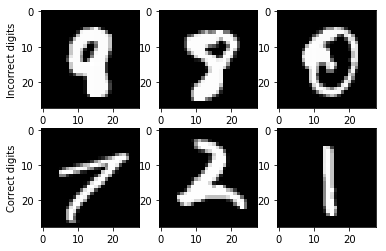

In [45]:
# Reload data
import random
import time

# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
input_shape = (None, 28 * 28)
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
    layers[-1],
    num_units=300,
    init_stddev=0.01,
    activation_fun=Activation('relu')
))


layers.append(FullyConnectedLayer(
    layers[-1],
    num_units=100,
    init_stddev=0.01,
    activation_fun=Activation('relu')
))


layers.append(FullyConnectedLayer(
    layers[-1],
    num_units=10,
    init_stddev=0.01,
    # last layer has no nonlinearity 
    # (softmax will be applied in the output layer)
    activation_fun=None
))
layers.append(SoftmaxOutput(layers[-1]))

Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval
X_test, y_test = Dtest

X_train = np.concatenate((X_train, X_valid), axis=0)
y_train = np.concatenate((y_train, y_valid), axis=0)

X_train_orig = X_train

X_train = X_train.reshape(X_train.shape[0], -1)
print("Reshaped X_train size: {}".format(X_train.shape))
X_test = X_test.reshape((X_test.shape[0], -1))
print("Reshaped X_test size: {}".format(X_test.shape))

nn_final = NeuralNetwork(layers)
num_epochs = 50
# # Train neural network
t0 = time.time()
train_errors, val_errors = nn_final.train(X_train, y_train, learning_rate=0.1, 
         max_epochs=num_epochs, batch_size=64, y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1 - t0))

plt.axis([0, num_epochs, 0, 20])
plt.xlabel("# Epochs")
plt.ylabel("Errors")
plt.plot(train_errors * 100, label='Train error')
plt.legend()
plt.savefig("Train-final.png")
# plt.show()

loss_test, error_test, classified = nn_final.test(X_test, y_test)

print("Test error ", error_test * 100, "%",)
print("Test loss", loss_test)

correct, incorrect = [], []
for i in range(len(classified)):
    if classified[i]:
        incorrect.append(i)
    else:
        correct.append(i)

wrong_digits = random.sample(incorrect, 3)
correct_digits = random.sample(correct, 3)
   

plt.figure(1)
plt.subplot(231)
plt.ylabel("Incorrect digits")
plt.imshow(X_test[wrong_digits[0]].reshape([28, 28]))

plt.subplot(232)
plt.imshow(X_test[wrong_digits[1]].reshape([28, 28]))

plt.subplot(233)
plt.imshow(X_test[wrong_digits[2]].reshape([28, 28]))

plt.subplot(234)
plt.ylabel("Correct digits")
plt.imshow(X_test[correct_digits[0]].reshape([28, 28]))

plt.subplot(235)
plt.imshow(X_test[correct_digits[1]].reshape([28, 28]))

plt.subplot(236)
plt.imshow(X_test[correct_digits[2]].reshape([28, 28]))
plt.gray()
plt.savefig("Digits.png")
plt.show()
